In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.metrics import mean_squared_error
from scipy import stats

In [4]:
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.al import top_model as topmodel
from DomainPrediction.al.embeddings import one_hot_encode

In [ ]:
from DomainPrediction.esm.esm2 import ESM2
from DomainPrediction.al.confit import ESM2ConFit

In [5]:
sys.path.append('../../esm')
from DomainPrediction.esm.esm3 import ESM3LM
from DomainPrediction.esm.esmc import ESMCLM
from DomainPrediction.al.confit import ESMCConFit

#### Load Data

In [6]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/GB1'

In [7]:
file = os.path.join(data_path, 'dataset_gb1.csv')
df = pd.read_csv(file)

In [8]:
df.head()

,seq,fitness_raw,split_id,n_mut,fitness_log
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.00,2,0,0.000000
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.45,2,1,0.371564
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.69,2,1,0.524729
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.17,2,1,0.157004
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.40,2,1,0.875469


In [9]:
results_file = os.path.join(data_path, 'results_GB1_zeroshot.csv')

In [10]:
if os.path.isfile(results_file):
    df_results = pd.read_csv(results_file)
else:
    df_results = df.copy()

In [11]:
df_results.head()

,seq,fitness_raw,split_id,n_mut,fitness_log,pred_ESM650M_masked_marginal,pred_ESM3_masked_marginal,pred_ESMC300M_masked_marginal,pred_ESMC600M_masked_marginal,pred_ESMC300M_confit
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.00,2,0,0.000000,0.000000,0.000000,0.000,0.000000,0.0000
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.45,2,1,0.371564,-0.079431,0.328125,0.250,0.492188,-0.0625
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.69,2,1,0.524729,0.555604,0.476562,0.750,0.867188,-0.1875
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.17,2,1,0.157004,-1.379841,-1.953125,-1.375,-1.375000,-1.1250
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.40,2,1,0.875469,0.137812,0.481445,-0.125,-0.312500,1.1250


In [12]:
df_results.columns[df_results.columns.str.contains('pred')]

Index(['pred_ESM650M_masked_marginal', 'pred_ESM3_masked_marginal',
       'pred_ESMC300M_masked_marginal', 'pred_ESMC600M_masked_marginal',
       'pred_ESMC300M_confit'],
      dtype='object')

In [13]:
len(df_results.columns[df_results.columns.str.contains('pred')])

5

In [14]:
def get_split_mask(df, omit_zero=False):
    if omit_zero:
        train_mask = (df['split_id'] == 2) & (df['fitness_raw'] != 0)
    else:
        train_mask = (df['split_id'] == 2)

    val_mask = df['split_id'] == 1
    test_mask = df['split_id'] == 0

    return train_mask, val_mask, test_mask

#### OHE

In [ ]:
embeddings = one_hot_encode(df['seq'])

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)

X_train = embeddings[train_mask]
X_val = embeddings[val_mask]
X_test = embeddings[test_mask]

# y_train = df.loc[train_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_val = df.loc[val_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_test = df.loc[test_mask, 'fitness_raw'].to_numpy().astype(np.float32)

y_train = df.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [ ]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_OHE_ridge'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_OHE_ridge'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_OHE_ridge'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
surrogate = topmodel.RFSurrogate()
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_OHE_RF'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_OHE_RF'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_OHE_RF'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
print(f'input layer shape: {X_train.shape[1]}')

In [ ]:
config={'layers': [5300, 512, 1], 
        'epoch': 100, 
        'batch_size': 16,
        'patience': 10,
        'early_stopping': True,
        'lr': 1e-3,
        'print_every_n_epoch': 10,
        'debug': True}
surrogate = topmodel.MLPSurrogate(config=config)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_OHE_MLP'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_OHE_MLP'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_OHE_MLP'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ESM2, ESM3 and ESMC Embeddings

In [ ]:
# esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
# esm3 = ESM3LM(device='gpu')
# esmc = ESMCLM(name='esmc_300m', device='gpu')
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
# embeddings = esm2.get_embeddings_flatten(df['seq'])
# embeddings = esm3.get_embeddings_flatten(df['seq'])
embeddings = esmc.get_embeddings_flatten(df['seq'])

In [ ]:
embeddings.shape

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)

X_train = embeddings[train_mask]
X_val = embeddings[val_mask]
X_test = embeddings[test_mask]

# y_train = df.loc[train_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_val = df.loc[val_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_test = df.loc[test_mask, 'fitness_raw'].to_numpy().astype(np.float32)

y_train = df.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [ ]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_ESMC600M_concat_ridge'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_concat_ridge'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_concat_ridge'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
surrogate = topmodel.RFSurrogate()
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_ESM650M_concat_RF'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESM650M_concat_RF'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESM650M_concat_RF'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
print(f'input layer shape: {X_train.shape[1]}')

In [ ]:
config={'layers': [265, 128, 1], 
        'epoch': 100, 
        'batch_size': 16,
        'patience': 20,
        'early_stopping': True,
        'lr': 1e-3,
        'print_every_n_epoch': 10,
        'debug': True}
surrogate = topmodel.MLPSurrogate(config=config)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_ESMC600M_feat_mean_MLP'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_feat_mean_MLP'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_feat_mean_MLP'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ESM2, ESM3, ESMC - ZeroShot Margials

In [ ]:
# esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
# esm3 = ESM3LM(device='gpu')
# esmc = ESMCLM(name='esmc_300m', device='gpu')
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
wt_sequence = helper.read_fasta(os.path.join(data_path, 'GB1_WT.fasta'), mode='str')[0]

In [ ]:
## masked marginals
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    # score, n_muts = esm2.get_masked_marginal(mt_sequence, wt_sequence)
    # score, n_muts = esm3.get_masked_marginal(mt_sequence, wt_sequence)
    score, n_muts = esmc.get_masked_marginal(mt_sequence, wt_sequence)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)

In [ ]:
y = df['fitness_log'].to_numpy().astype(np.float32)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3,3), layout='constrained')

ax.plot(y, y_pred, '.', alpha=0.5)
mse = mean_squared_error(y, y_pred)
corr = stats.spearmanr(y, y_pred)
s_corr = round(corr.statistic, 2)
ax.set_title(f'Full Dataset \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')

train_mask, val_mask, test_mask = get_split_mask(df)

for i, (dset, _mask) in enumerate(zip(['train', 'val', 'test'], 
                                      [train_mask, val_mask, test_mask])):
    ax[i].plot(y[_mask], y_pred[_mask], '.', alpha=0.5)
    mse = mean_squared_error(y[_mask], y_pred[_mask])
    corr = stats.spearmanr(y[_mask], y_pred[_mask])
    s_corr = round(corr.statistic, 2)
    ax[i].set_title(f'{dset} \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

In [ ]:
# assert y_pred.shape[0] == df_results.shape[0]
# df_results['pred_ESMC600M_masked_marginal'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_masked_marginal'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_masked_marginal'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ConFit - Contrastive Fitness Learning

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)
df_train = df[train_mask]
df_val = df[val_mask]
df_test = df[test_mask]

In [ ]:
config={'epoch': 10, 
        'batch_size': 8,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 20,
        'early_stopping': False,
        'lr': 5e-4,
        'print_every_n_epoch': 1,
        'device': 'gpu'}
surrogate = ESMCConFit(name='esmc_300m', config=config)
surrogate.print_trainable_parameters(surrogate.model)

In [ ]:
wt_sequence = helper.read_fasta(os.path.join(data_path, 'GB1_WT.fasta'), mode='str')[0]

In [ ]:
surrogate.sanity_check(df_train, wt_sequence)

In [ ]:
surrogate.trainmodel(df_train, wt_sequence, df_val)

In [ ]:
## masked marginals
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    score, n_muts = surrogate.get_masked_marginal(mt_sequence, wt_sequence)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)
y = df['fitness_log'].to_numpy().astype(np.float32)

In [ ]:
y_train_pred, y_train = y_pred[train_mask], y[train_mask]
y_val_pred, y_val = y_pred[val_mask], y[val_mask]
y_test_pred, y_test = y_pred[test_mask], y[test_mask]

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.8)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.8)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.8)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
omit_mask = df['fitness_raw'] != 0
y_train_pred, y_train = y_pred[train_mask & omit_mask], y[train_mask & omit_mask]
y_val_pred, y_val = y_pred[val_mask & omit_mask], y[val_mask & omit_mask]
y_test_pred, y_test = y_pred[test_mask & omit_mask], y[test_mask & omit_mask]

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.8)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.8)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.8)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# assert y_pred.shape[0] == df_results.shape[0]
# df_results['pred_ESMC300M_confit'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC300M_confit'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC300M_confit'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### Simulation Low-N setting

In [15]:
n_samples = 53

In [16]:
omit_mask = df['fitness_raw'] != 0
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)
print(f'n samples: train {train_mask.sum()} val {val_mask.sum()} test {test_mask.sum()}')

mut_mask = df['n_mut'].isin([0, 1, 2])
random_indices = df[train_mask & omit_mask & mut_mask].sample(n=n_samples, random_state=0).index
selected_mask = df.index.isin(random_indices)

train_mask_selected = selected_mask
train_mask_rest = train_mask & ~selected_mask
print(f'n samples: train selected {train_mask_selected.sum()} train rest {train_mask_rest.sum()}')

df_train = df[train_mask_selected]
df_train_rest = df[train_mask_rest]
df_val = df[val_mask]
df_test = df[test_mask]

n samples: train 2691 val 299 test 5743
n samples: train selected 53 train rest 2638


In [17]:
df_train.shape[0] + df_train_rest.shape[0] + df_val.shape[0] + df_test.shape[0] == df.shape[0]

True

In [ ]:
# Index([124, 303, 319, 373, 208, 104, 256, 147,  77,  52, 307, 174,  60, 280,
#        363, 222,  54, 171, 360, 323, 148,  37, 253, 203, 281,  79, 225, 260,
#          6,   1, 284,  91,  65, 229, 138, 215, 165, 146,  10,  26,  75, 313,
#        317, 383,  45,  15, 316, 380,   5,  68, 237,   7, 244],
#       dtype='int64')

In [18]:
random_indices

Index([124, 303, 319, 373, 208, 104, 256, 147,  77,  52, 307, 174,  60, 280,
       363, 222,  54, 171, 360, 323, 148,  37, 253, 203, 281,  79, 225, 260,
         6,   1, 284,  91,  65, 229, 138, 215, 165, 146,  10,  26,  75, 313,
       317, 383,  45,  15, 316, 380,   5,  68, 237,   7, 244],
      dtype='int64')

In [19]:
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [20]:
embeddings = esmc.get_embeddings_flatten(df['seq'])

100%|██████████| 8733/8733 [04:50<00:00, 30.10it/s]


In [21]:
X_train = embeddings[train_mask_selected]
X_val = embeddings[val_mask]

y_train = df.loc[train_mask_selected, 'fitness_log'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [22]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

train: mse = 0.21966777741909027, spearman correlation = 0.817677789223044
val: mse = 17.456695556640625, spearman correlation = 0.44995716460769153


In [23]:
y_pred = surrogate.predict(embeddings)
y = df['fitness_log'].to_numpy().astype(np.float32)

In [24]:
def get_spearmanr_bootstrap(a, b, n=1000):
    assert type(a) == type(b) == np.ndarray
    assert len(a) == len(b)
    corr = []
    p_value = []
    np.random.seed(0)
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        res = stats.spearmanr(a[indices], b[indices])
        
        if not np.isnan(res.statistic):
            corr.append(res.statistic)
            p_value.append(res.pvalue)

    ci_lower, ci_upper = np.percentile(corr, [5, 95]) 
    # stats.t.interval(confidence=0.95, df=len(corr)-1, loc=np.mean(corr), scale=np.std(corr))
    mean_corr = np.mean(corr)

    return round(mean_corr, 2), round(ci_lower, 2), round(ci_upper, 2), corr, p_value

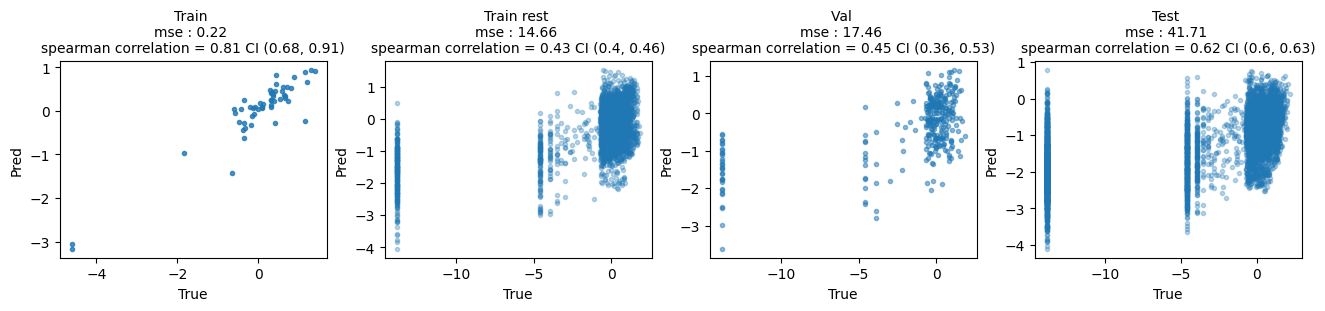

In [25]:
fig, ax = plt.subplots(1,4, figsize=(13,3), layout='constrained')

ax[0].plot(y[train_mask_selected], y_pred[train_mask_selected], '.', alpha=0.8)
ax[1].plot(y[train_mask_rest], y_pred[train_mask_rest], '.', alpha=0.3)
ax[2].plot(y[val_mask], y_pred[val_mask], '.', alpha=0.5)
ax[3].plot(y[test_mask], y_pred[test_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected], y_pred[train_mask_selected])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[train_mask_selected], y_pred[train_mask_selected])
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[train_mask_rest], y_pred[train_mask_rest])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[train_mask_rest], y_pred[train_mask_rest])
ax[1].set_title(f'Train rest \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[val_mask], y_pred[val_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[val_mask], y_pred[val_mask])
ax[2].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[test_mask], y_pred[test_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[test_mask], y_pred[test_mask])
ax[3].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(4):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

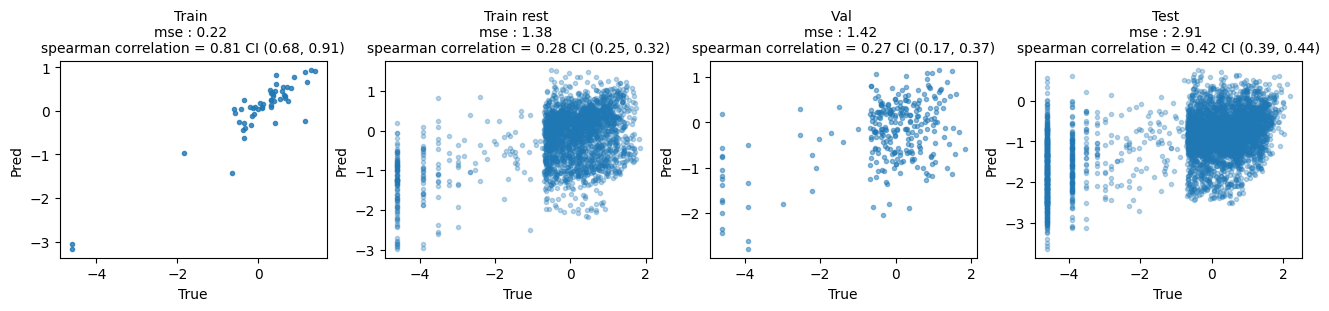

In [26]:
fig, ax = plt.subplots(1,4, figsize=(13,3), layout='constrained')

ax[0].plot(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask], '.', alpha=0.8)
ax[1].plot(y[train_mask_rest & omit_mask], y_pred[train_mask_rest & omit_mask], '.', alpha=0.3)
ax[2].plot(y[val_mask & omit_mask], y_pred[val_mask & omit_mask], '.', alpha=0.5)
ax[3].plot(y[test_mask & omit_mask], y_pred[test_mask & omit_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[train_mask_rest & omit_mask], y_pred[train_mask_rest & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[train_mask_rest & omit_mask], y_pred[train_mask_rest & omit_mask])
ax[1].set_title(f'Train rest \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
ax[2].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
ax[3].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(4):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

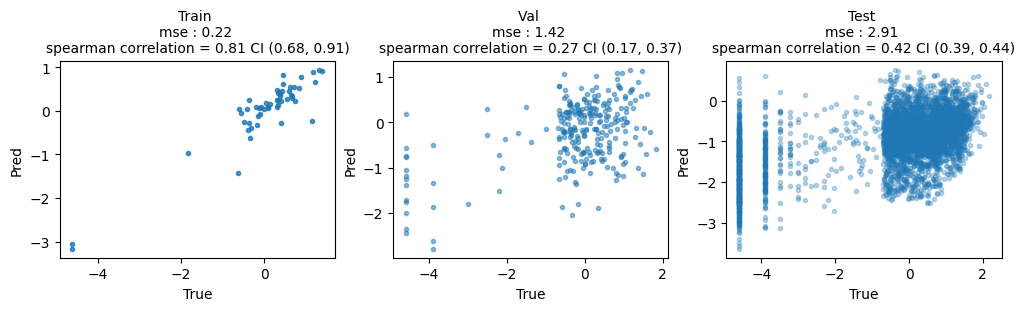

In [28]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')

ax[0].plot(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask], '.', alpha=0.8)
ax[1].plot(y[val_mask & omit_mask], y_pred[val_mask & omit_mask], '.', alpha=0.5)
ax[2].plot(y[test_mask & omit_mask], y_pred[test_mask & omit_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [29]:
config={'epoch': 30, 
        'batch_size': 8,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 20,
        'early_stopping': False,
        'lr': 5e-4,
        'print_every_n_epoch': 1,
        'device': 'gpu'}
surrogate = ESMCConFit(name='esmc_600m', config=config)
surrogate.print_trainable_parameters(surrogate.model)

trainable params: 746496 || all params: 575700544 || trainable%: 0.13


In [30]:
wt_sequence = helper.read_fasta(os.path.join(data_path, 'GB1_WT.fasta'), mode='str')[0]

In [31]:
surrogate.sanity_check(df_train, wt_sequence)

In [32]:
surrogate.trainmodel(df_train, wt_sequence, df_val)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 12GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-01-16 13:56:27.474373: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 13:56:27.476792: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 13:56:27.481737: E externa

Epoch: 0: train loss: 26.439827510288783 val loss: 29.396655961086875
Epoch: 1: train loss: 27.864875861576625 val loss: 29.50227155183491
Epoch: 2: train loss: 26.24729851314 val loss: 28.98081145788494
Epoch: 3: train loss: 27.00666277749198 val loss: 28.900539084484702
Epoch: 4: train loss: 28.814008712768555 val loss: 28.616664158670527
Epoch: 5: train loss: 26.926603044782365 val loss: 28.291668101360923
Epoch: 6: train loss: 24.317701748439244 val loss: 28.224867356450932
Epoch: 7: train loss: 22.492815562656947 val loss: 27.667526998017962
Epoch: 8: train loss: 23.426012992858887 val loss: 27.57728560347306
Epoch: 9: train loss: 22.49451814379011 val loss: 27.51809753869709
Epoch: 10: train loss: 22.635026386805944 val loss: 27.552092677668522
Epoch: 11: train loss: 20.909724916730607 val loss: 27.264166894711945
Epoch: 12: train loss: 20.63855811527797 val loss: 26.68603612247266
Epoch: 13: train loss: 22.236251286097936 val loss: 26.326187146337407
Epoch: 14: train loss: 20.45

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch: 30: train loss: 17.30761977604457 val loss: 27.613090352008218


In [33]:
## masked marginals
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    score, n_muts = surrogate.get_masked_marginal(mt_sequence, wt_sequence)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)
y = df['fitness_log'].to_numpy().astype(np.float32)

8733it [05:32, 26.26it/s]


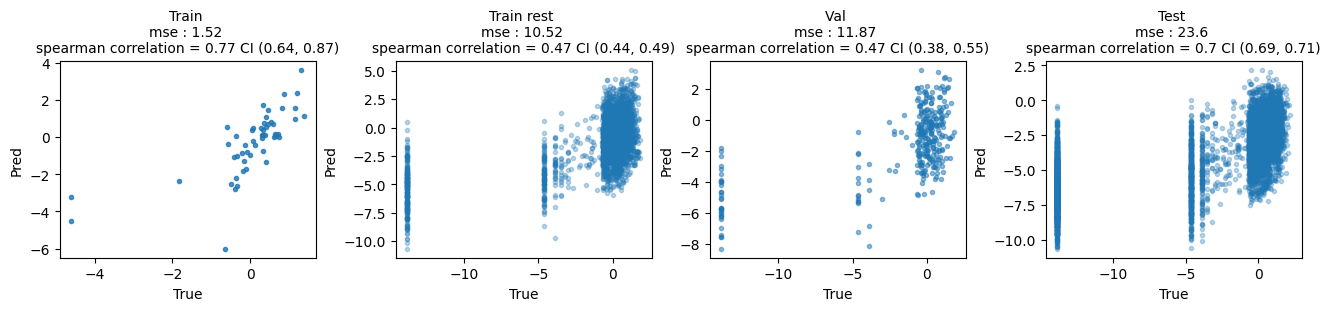

In [34]:
fig, ax = plt.subplots(1,4, figsize=(13,3), layout='constrained')

ax[0].plot(y[train_mask_selected], y_pred[train_mask_selected], '.', alpha=0.8)
ax[1].plot(y[train_mask_rest], y_pred[train_mask_rest], '.', alpha=0.3)
ax[2].plot(y[val_mask], y_pred[val_mask], '.', alpha=0.5)
ax[3].plot(y[test_mask], y_pred[test_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected], y_pred[train_mask_selected])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[train_mask_selected], y_pred[train_mask_selected])
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[train_mask_rest], y_pred[train_mask_rest])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[train_mask_rest], y_pred[train_mask_rest])
ax[1].set_title(f'Train rest \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[val_mask], y_pred[val_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[val_mask], y_pred[val_mask])
ax[2].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[test_mask], y_pred[test_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[test_mask], y_pred[test_mask])
ax[3].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(4):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

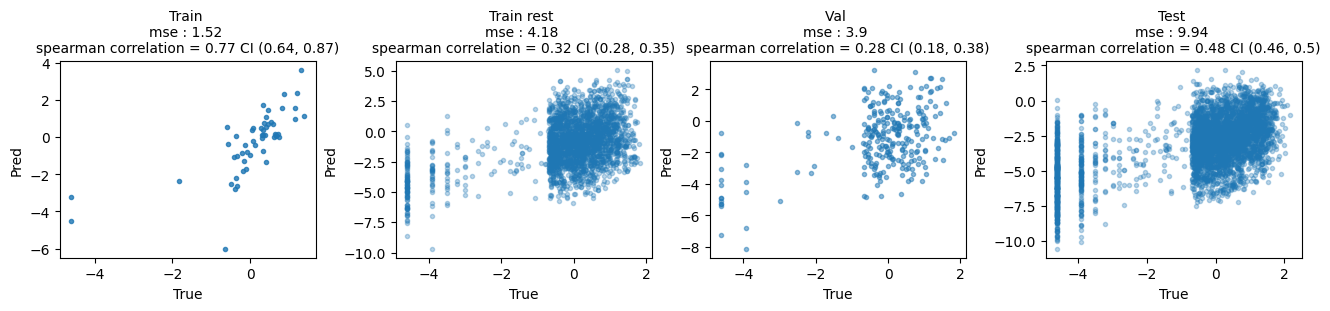

In [35]:
fig, ax = plt.subplots(1,4, figsize=(13,3), layout='constrained')

ax[0].plot(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask], '.', alpha=0.8)
ax[1].plot(y[train_mask_rest & omit_mask], y_pred[train_mask_rest & omit_mask], '.', alpha=0.3)
ax[2].plot(y[val_mask & omit_mask], y_pred[val_mask & omit_mask], '.', alpha=0.5)
ax[3].plot(y[test_mask & omit_mask], y_pred[test_mask & omit_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[train_mask_rest & omit_mask], y_pred[train_mask_rest & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[train_mask_rest & omit_mask], y_pred[train_mask_rest & omit_mask])
ax[1].set_title(f'Train rest \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
ax[2].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
ax[3].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(4):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

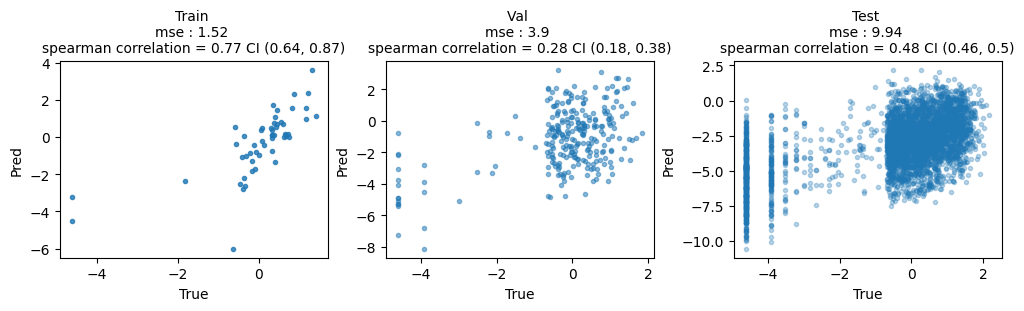

In [36]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')

ax[0].plot(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask], '.', alpha=0.8)
ax[1].plot(y[val_mask & omit_mask], y_pred[val_mask & omit_mask], '.', alpha=0.5)
ax[2].plot(y[test_mask & omit_mask], y_pred[test_mask & omit_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()